- Create new features (e.g., bathroomCount/bedroomCount, price per m²)
- Remove or combine weak/redundant features
- Try log-transforming price if it’s heavily skewed

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("dataset_wout_price_outliers.csv")  # Replace with your path

# --- Feature Engineering ---
# 1. Create bathroom-to-bedroom ratio
df["bath_per_bed"] = df["bathroomCount"] / df["bedroomCount"]
df["bath_per_bed"] = df["bath_per_bed"].replace([np.inf, -np.inf], np.nan).fillna(0)

# 2. Create price per square meter (m2)
# df["price_per_m2"] = df["price"] / df["habitableSurface"]
# df["price_per_m2"] = df["price_per_m2"].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Remove weak or redundant features ---
# 3. Drop constant or near-zero variance features
low_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=low_variance_cols, inplace=True)

# Optional: drop highly correlated features (keep only one)
corr_matrix = df.corr(numeric_only=True)
high_corr_pairs = [
    (col1, col2) for col1 in corr_matrix.columns 
    for col2 in corr_matrix.columns 
    if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.95
]
to_drop = set(pair[1] for pair in high_corr_pairs)
df.drop(columns=list(to_drop), inplace=True)

# --- Check & Apply Log Transformation on Price ---
# 4. Check skewness
skewness = df["price"].skew()
print(f"Original Price Skewness: {skewness:.2f}")

# 5. Apply log1p if skewed
if abs(skewness) > 1:
    df["price_log"] = np.log1p(df["price"])
    print("Applied log1p transformation to `price` ➝ new column `price_log`")
else:
    print("Skewness not high — no log transform applied.")
# Check correlation of all features with target

corrs = df.corr()['price'].sort_values(ascending=False)
# print(f'here is the correltion score: {corrs}')
# Save result
df.to_csv("processed_dataset.csv", index=False)
print("Processed dataset saved as 'processed_dataset.csv'")

Original Price Skewness: 0.87
Skewness not high — no log transform applied.
Processed dataset saved as 'processed_dataset.csv'


- Start with Random Forest or Ridge Regression
- Use GridSearchCV or RandomizedSearchCV to tune parameters (e.g., number of trees, max depth)
- Try ensemble models like XGBoost or LightGBM — they often outperform others

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load processed dataset
df = pd.read_csv("processed_dataset.csv")

# Choose target variable
target_col = "price_log" if "price_log" in df.columns else "price"
corrs = df.corr()['price'].sort_values(ascending=False)
# print(f'here is the correltion score: {corrs}')
# Define features and target
X = df.drop(columns=["price", "price_log"] if "price_log" in df.columns else ["price"])
y = df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data (for Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Define Models and Parameter Grids ---

# 1. Random Forest
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

# 2. Ridge Regression
ridge_params = {
    "alpha": [0.1, 1.0, 10.0],
}

# 3. XGBoost
xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.05, 0.1],
}

# 4. LightGBM
lgbm_params = {
    "n_estimators": [100, 200],
    "max_depth": [-1, 10],
    "learning_rate": [0.05, 0.1],
}

# --- Perform Grid Search ---

def tune_model(model, params, X, y, model_name):
    print(f" Tuning {model_name}...")
    grid = GridSearchCV(model, params, scoring="r2", cv=3, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print(f" Best {model_name} Params: {grid.best_params_}")
    return grid.best_estimator_

# Tune all models
rf_model = tune_model(RandomForestRegressor(random_state=42), rf_params, X_train, y_train, "Random Forest")
ridge_model = tune_model(Ridge(), ridge_params, X_train_scaled, y_train, "Ridge Regression")
xgb_model = tune_model(XGBRegressor(random_state=42, verbosity=0), xgb_params, X_train, y_train, "XGBoost")
lgbm_model = tune_model(LGBMRegressor(random_state=42), lgbm_params, X_train, y_train, "LightGBM")

# --- Evaluate All Models ---
models = {
    "Random Forest": rf_model,
    "Ridge Regression": ridge_model,
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model
}

print("\nModel Performance on Test Set:")
for name, model in models.items():
    X_eval = X_test_scaled if name == "Ridge Regression" else X_test
    y_pred = model.predict(X_eval)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: R² = {r2:.3f}, MSE = {mse:.2f}")

here is the correltion score: price                            1.000000
bedroomCount                     0.405676
toiletCount                      0.380974
bathroomCount                    0.357685
totalParkingCount                0.232839
epcScore_encoded                 0.230839
type_encoded                     0.187026
hasPhotovoltaicPanels_encoded    0.185391
hasOffice_encoded                0.177470
subtype_encoded                  0.170885
hasHeatPump_encoded              0.165670
hasFireplace_encoded             0.128654
hasSwimmingPool_encoded          0.125304
hasTerrace_encoded               0.121023
hasDressingRoom_encoded          0.118713
hasGarden_encoded                0.101553
habitableSurface                 0.057637
hasArmoredDoor_encoded           0.057386
hasAirConditioning_encoded       0.057129
hasVisiophone_encoded            0.046434
hasDiningRoom_encoded            0.044483
hasAttic_encoded                 0.043859
locality_encoded                 0.023566
hasL

- MSE / RMSE
- Residual plots (errors vs actual)
- Feature importance
- Use cross-validation for more reliable evaluation


 Random Forest Evaluation
R²: 0.698
MSE: 8095260118.59
RMSE: 89973.66
CV R² scores: [0.69012965 0.70039727 0.6962979  0.68677254 0.689898  ]
Mean CV R²: 0.693


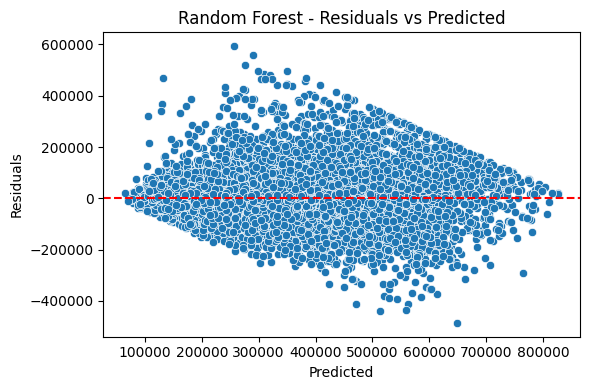

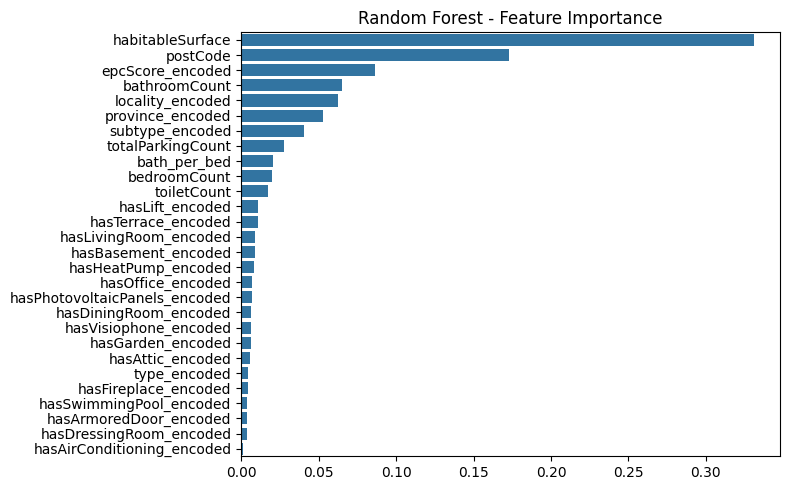


 Ridge Regression Evaluation
R²: 0.433
MSE: 15175374345.55
RMSE: 123188.37
CV R² scores: [ 0.43983414 -3.00295284  0.43982121  0.44280818  0.43138675]
Mean CV R²: -0.250


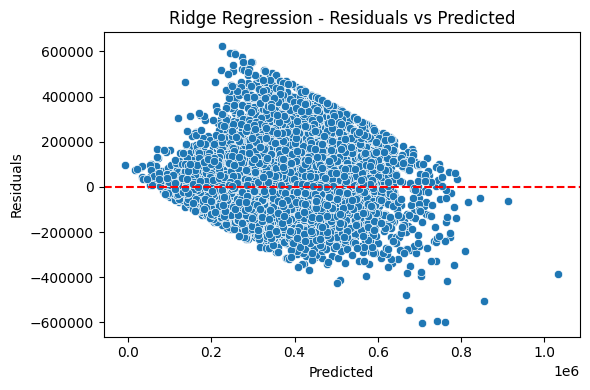


 XGBoost Evaluation
R²: 0.723
MSE: 7428117288.96
RMSE: 86186.53
CV R² scores: [0.71770459 0.72856091 0.72752068 0.71643644 0.7204037 ]
Mean CV R²: 0.722


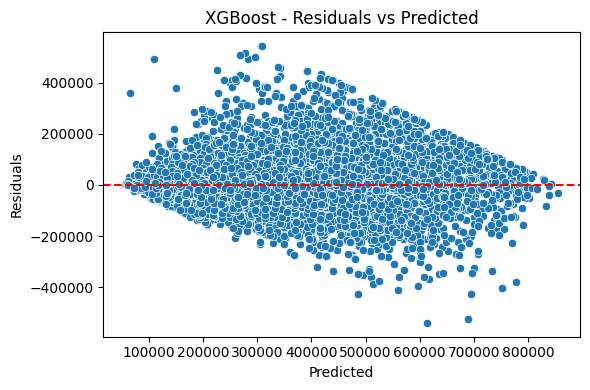

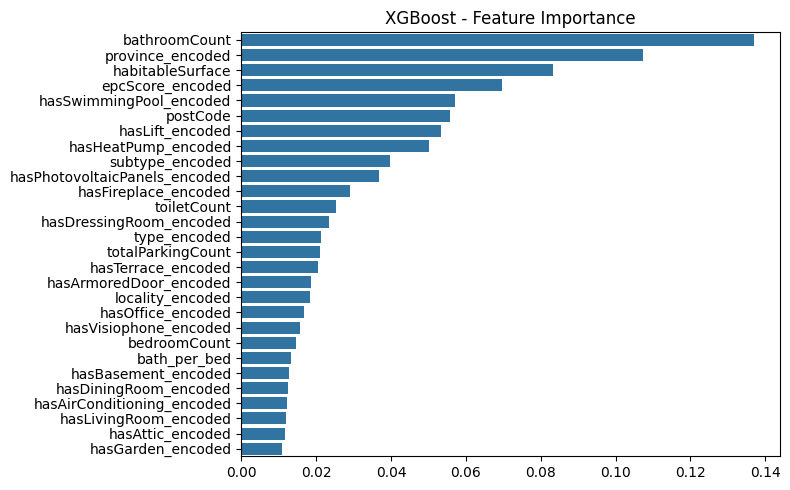


 LightGBM Evaluation
R²: 0.704
MSE: 7929420295.22
RMSE: 89047.29
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 44931, number of used features: 28
[LightGBM] [Info] Start training from score 344246.981327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 44931, number of used features: 28
[LightGBM] [Info] Start training from score 344385.423449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004743 seconds.
You can se

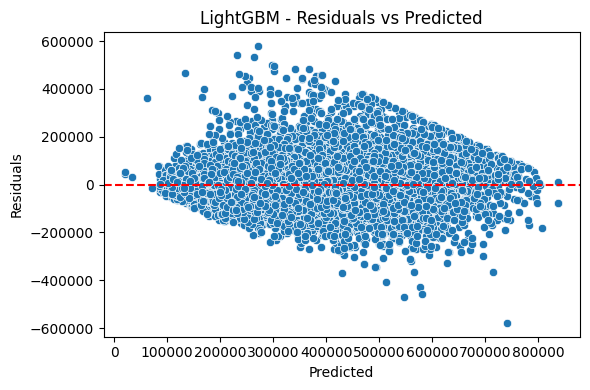

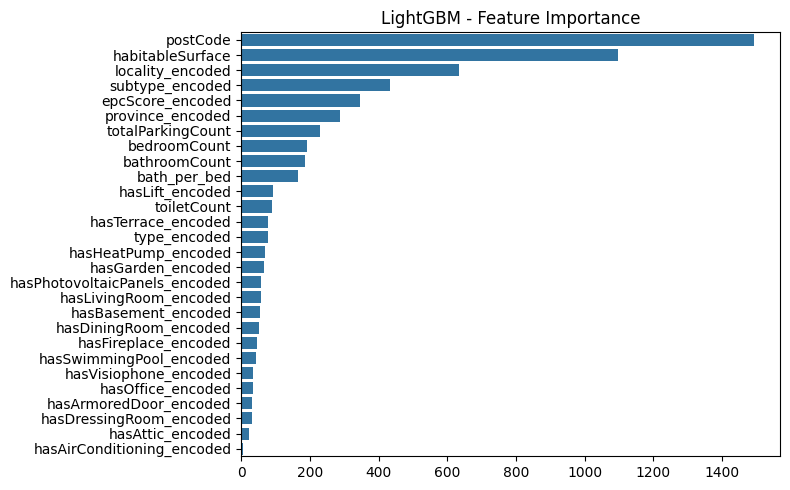

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Evaluate a single model
def evaluate_model(name, model, X_train, y_train, X_test, y_test, scaled=False):
    print(f"\n {name} Evaluation")
    
    # Use scaled or original features
    X_train_eval = X_train_scaled if scaled else X_train
    X_test_eval = X_test_scaled if scaled else X_test
    
    # Predictions
    y_pred = model.predict(X_test_eval)

    # R², MSE, RMSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"R²: {r2:.3f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Cross-validation score (R²)
    cv_scores = cross_val_score(model, X_train_eval, y_train, cv=5, scoring='r2')
    print(f"CV R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.3f}")

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} - Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Feature importance (tree-based models only)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        features = X_train.columns
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importance[sorted_idx], y=np.array(features)[sorted_idx])
        plt.title(f"{name} - Feature Importance")
        plt.tight_layout()
        plt.show()

# Evaluate all models
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)
evaluate_model("Ridge Regression", ridge_model, X_train, y_train, X_test, y_test, scaled=True)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)
evaluate_model("LightGBM", lgbm_model, X_train, y_train, X_test, y_test)

#### Advanced Techniques
- Try Stacking: combine multiple models (e.g., linear + forest)
- Use SHAP or LIME for model explainability
- Use PCA or feature selection to reduce dimensionality

In [4]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define base models
base_models = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

# Define meta-model
meta_model = Ridge(alpha=1.0)

# Create stacking model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Train the model
stacking_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = stacking_model.predict(X_test_scaled)
print("Stacking R²:", r2_score(y_test, y_pred))

Stacking R²: 0.999178140865421


🔍 Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Random Forest Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


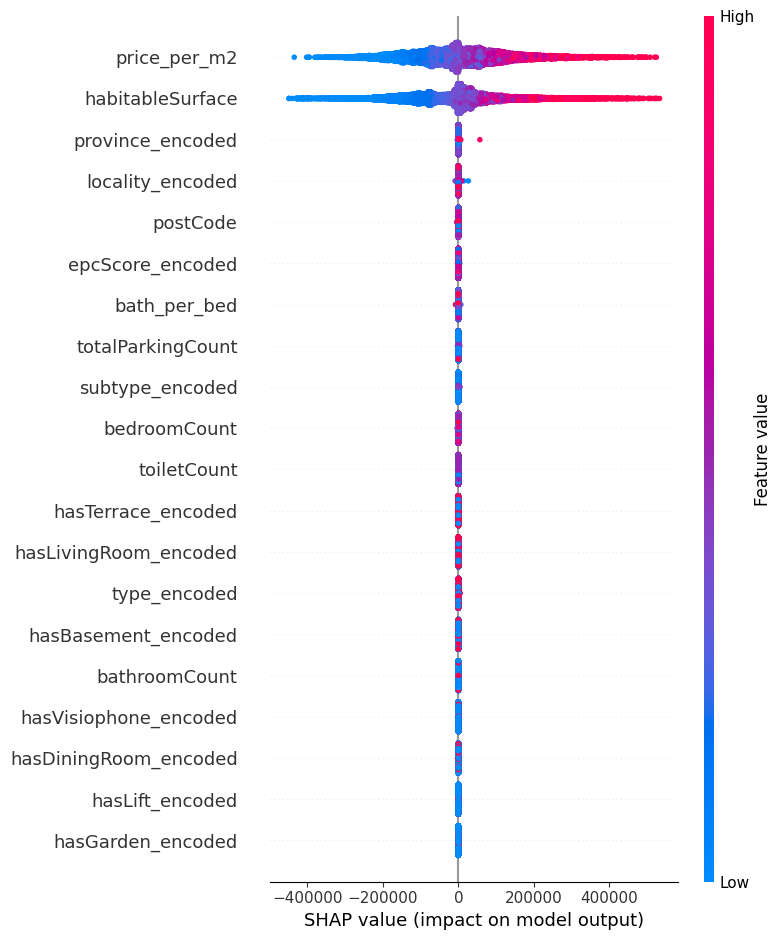

In [6]:
import shap

def tune_model(model, params, X, y, model_name):
    print(f"🔍 Tuning {model_name}...")
    grid = GridSearchCV(model, params, scoring="r2", cv=3, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print(f"Best {model_name} Params: {grid.best_params_}")
    return grid.best_estimator_

# Earlier in your pipeline:
rf_model = tune_model(RandomForestRegressor(random_state=42), rf_params, X_train, y_train, "Random Forest")
# Create explainer for tree model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)